# Matched Discrimination Analysis

In [1]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy.stats import sem 
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from sklearn.linear_model import LinearRegression


## Load in data if pipeline has already been run through

In [3]:
_dir = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination'
# raw_dir = _dir + '/data/finalVEMatched/raw/'
zs_dir = _dir + '/data/finalDiscrimMatched/z_scored_RT/'

# final_data = pd.read_csv (raw_dir + '/raw_discrim.csv')
zscored_data = pd.read_csv (zs_dir + 'final_discrim.csv')

In [107]:
def combineCSVs(datafolder, num_discrim_trials):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    
    returns:
        (1) combined dataframe of all discrimination data 
        (2) combined dataframe of all scene property rating data 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        discrim_data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                df_discrim = df[0:num_discrim_trials]
                discrim_data.append(df_discrim)

        discrim_frame = pd.concat(discrim_data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            df = pd.read_csv(datafolder, index_col=None, header=0)
            df_discrim = df[0:num_discrim_trials]
            discrim_data.append(df_discrim)
 
    return discrim_frame

In [108]:
data_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/BNav_EC2/DepthDuration/v2_depth_discrimination_MTurk/data'
num_total_trials = 86

In [109]:
raw_discrim = combineCSVs(data_path, num_total_trials)

In [110]:
# raw_discrim

In [111]:
all_subjIDs = raw_discrim.subjID.unique()
len(all_subjIDs)

1060

In [112]:
all_ages = raw_discrim.age.unique()
all_ages

array([  24,   28,   31,   38,   45,   33,   35,   34,   55,   27,   32,
         50,   40,   51,   58,   29,   36,   46,   25,   42,   48,   30,
         37,   41,   26,   53,   64, 1997,   61,   57,   47,   22,   23,
         70, 1970, 1994,   56,   59,   52,   44,   21,   43,   69, 1974,
         62,   49, 1990,   65, 1989,   39, 1960, 1965,   60, 1976,   63,
         19,   54, 1985,   67,   20, 1971, 1963,   66, 1980,   77,   76,
         71, 1973,   68, 1966, 1959, 1964])

## <font color='red'> Data Cleaning </font> 



In [113]:
def catchTrial_cleaning(df, correct_requirement, catch_stimuli):
    '''
    Participants complete 8 catch trials total to ensure that they are doing the task.
    If less than 6/8 catch trials are correct, the participant is excluded.  
    '''
    all_subjIDs = df.subjID.unique()
    remove = []
    subj_sequence = {}
    df2_list = []
    
    for subj in all_subjIDs:
        count_correct = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        # 
        subj_sequence[subj] = subj_df.sequenceName.unique()[0]
        
        # remove trials that are outside the outlier range
        c = 0
        c_missed = 0
        for idx, row in subj_df.iterrows():
            stim1 = row['stimulus_0']
            stim2 = row['stimulus_1']
            # TEMP SOLUTION FOR RANDOM PHP DATA SAVING PROBLEM 
            if type(stim1) == str:
                if stim1.split('/')[1] in catch_stimuli or stim2.split('/')[1] in catch_stimuli:
                    ####### VERSION WHERE CATCH TRIALS ARE ATTENTION CHECK: IMAGE 1 IS THE SAME AS IMAGE 2
                    c += 1
                    if row["discrim_choice"] == 3:
#                         print(row["discrim_choice"])
                        count_correct += 1
#                     else:
#                         print(row["discrim_choice"])
                    # remove catch trial 
                    cleaned_subj_df.drop([idx], inplace=True)
    #                 print(depth0, depth1, correct_choice, choice)
#         print(c_missed, 'Number of catch trials where participants did not see the target')
#         print(c)
#         print(count_correct)
        if count_correct < correct_requirement:
#             print('Number correct:', count_correct)
            remove.append(subj)

        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of participants that did not pass the catch trial check:", len(remove))

#     for index, row in df2.iterrows():
#         if row['subjID'] in remove:
#             df2.drop(index, inplace=True)
            
    for subj in remove:
        df2.drop(df2[df2['subjID'] == subj].index, inplace = True) 
    
    return df2
    
    

In [114]:
sequences_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/BNav_EC2/DepthDuration/v2_depth_discrimination_MTurk/discrim_jsons'
sequences_count_dict = {}
for seq in os.listdir(sequences_path):
    if 'json' in seq:
        sequences_count_dict['discrim_jsons/'+seq] = 0


In [115]:
all_catch_stim = ['000375_2014-06-08_11-17-29_260595134347_rgbf000133-resize_2',
                  '000569_2014-06-09_22-51-47_260595134347_rgbf000141-resize_3',
                  '000787_2014-06-08_22-33-53_260595134347_rgbf000175-resize_1',
                  '002072_2014-06-24_21-48-06_260595134347_rgbf000115-resize_0',
                  '001170_2014-06-17_15-43-44_260595134347_rgbf000096-resize_6',
                  '001222_2014-06-17_16-24-06_260595134347_rgbf000073-resize_0',
                  '001498_2014-06-19_17-45-14_260595134347_rgbf000129-resize_4',
                  '001540_2014-06-20_17-01-05_260595134347_rgbf000086-resize_2']

In [116]:
catch_cleaned_discrim = catchTrial_cleaning(raw_discrim, 6, all_catch_stim)

Number of participants that did not pass the catch trial check: 578


In [117]:
cleaned_ages = catch_cleaned_discrim.age.unique()
cleaned_ages

array([  28,   31,   38,   45,   33,   35,   34,   27,   50,   40,   51,
         58,   29,   36,   42,   55,   37,   25,   26,   53,   61,   22,
         46,   24, 1970,   30,   41,   56,   52,   44,   32,   43,   69,
         47,   48,   62,   49,   64, 1989,   39,   21,   60,   63,   65,
         57,   20,   67,   59,   66, 1980,   77,   54,   76,   23,   68])

In [118]:
def RT_cleaning(df, outlier_range, num_trials):
    all_subjIDs = df.subjID.unique()
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        
        # calculate subject's average trial RT
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()
        
        # remove trials that are outside the outlier range
        for idx, row in subj_df.iterrows():
            RT = row['trial_RT']
            if RT < outlier_range[0]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(num_trials * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of Participants with 10% or more trials outside their RT range:", len(remove))
    
#     for index, row in df2.iterrows():
#         if row['subjID'] in remove:
#             df2.drop(index, inplace=True)
            
    for subj in remove:
        df2.drop(df2[df2['subjID'] == subj].index, inplace = True) 
    
    return df2


In [119]:
cleaned_discrim = RT_cleaning(catch_cleaned_discrim, [250,10000], 78)



Number of Participants with 10% or more trials outside their RT range: 15


In [120]:
def finalTrialCountCheck(df, num_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column\n",
    all_subjIDs = df.subjID.unique()
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)
        
        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
    print("Number of Participants with >= 10% trials removed:", len(remove))
    
#     for index, row in df.iterrows():
#         if row['subjID'] in remove:
#             df.drop(index, inplace=True)
            
    for subj in remove:
        df.drop(df[df['subjID'] == subj].index, inplace = True) 
    
    print("Number of participants left:",len(df.subjID.unique()))
    
    return df

In [230]:
final_discrim = finalTrialCountCheck(cleaned_discrim, 78)

Number of Participants with >= 10% trials removed: 0
Number of participants left: 467


In [231]:
final_discrim_125_RTs = final_discrim.loc[final_discrim['duration']==125]['trial_RT']
final_discrim_250_RTs = final_discrim.loc[final_discrim['duration']==250]['trial_RT']
final_discrim_1000_RTs = final_discrim.loc[final_discrim['duration']==1000]['trial_RT']

(array([ 366., 8908., 1807.,  528.,  243.,   99.,   55.,   28.,   27.,
          13.]),
 array([ 726. , 1645.4, 2564.8, 3484.2, 4403.6, 5323. , 6242.4, 7161.8,
        8081.2, 9000.6, 9920. ]),
 <a list of 10 Patch objects>)

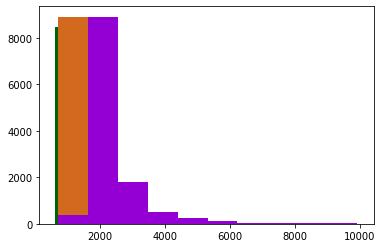

In [232]:
plt.hist(final_discrim_125_RTs, color = 'darkgreen')
plt.hist(final_discrim_250_RTs, color = 'chocolate')
plt.hist(final_discrim_1000_RTs, color = 'darkviolet')

### Z-Score RT 

In [233]:
def zscored_outcomes(df):
    '''
    z-score RTs:
        for each subj calculate their avg and std 
        zscored = (estim - subj avg)/subj std
    '''
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    df2_list = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        final_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        # Z-Score RT
        stimulus_duration = subj_df.log_sceneDuration2.unique()[0]
#         average_RT = subj_df["trial_RT"].mean()
#         std_RT = subj_df["trial_RT"].std()
        # remove stimulus duration and mask time
        subj_RTs = np.array(list(subj_df["trial_RT"])) - (stimulus_duration)
        average_RT = np.mean(subj_RTs)
        std_RT = np.std(subj_RTs)
        
        if std_RT < 1:
            print(std_RT)
            print(subj_RTs)
            print(subj)
            
        else:
            zscored_subj_RTs = (subj_RTs - average_RT)/std_RT


            final_subj_df.insert(12, "z_scored_RT", zscored_subj_RTs, True)
            final_subj_df.insert(13, "cleaned_RT", subj_RTs, True)

            df2_list.append(final_subj_df)
    
    df2 = pd.concat(df2_list)    

    return df2
     

In [234]:
zscored_data = zscored_outcomes(final_discrim)

0.0
[1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926.
 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926.
 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926.
 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926.
 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926.
 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926.]
572540.0


In [315]:
np.mean(np.array(zscored_data['z_scored_RT']))

2.0687881528880618e-17

In [219]:
# sequences that are completed

sampled_urls = zscored_data.url.unique()


<!-- ## Sequences that need replacing

Final N = 192 

Each sequence should have 48 participants -->

In [991]:
# final list of subjects 
# zscored_data.subjID.unique()

# Correlation with Verbal Report data 

- For each discrimination trial, get the average difference between the verbal report for those scenes 
- Correlate that with the proportion correct for that trial 
- Is there better accuracy for scenes that have a larger percevied depth difference (using the verbal report data)?

## Individual Discriminations

In [235]:
def get_accuracy(df):
    """
    * ACCURACY BASED ON THE KINECT
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    for idx, row in df.iterrows():
        choice = row["discrim_choice"]
        if choice == 2.0:
            count_missed += 1
        else:    
            count_total += 1
            depth0 = row["actual_depth_0"]
            depth1 = row["actual_depth_1"]
            if depth0 < depth1:
                correct_choice = 0
            if depth0 > depth1:
                correct_choice = 1
            if depth0 == depth1:
                # case where depths are equal 
                correct_choice = None
            if choice == correct_choice:
                count_correct += 1
    
    return count_correct/count_total, count_correct, count_total, count_missed

def get_RT(df):
    """
    args:
        df  
    returns:
        array of RTs, avg RT and std   
    """
    list_RTs = []
    for idx, row in df.iterrows():   
#         list_RTs.append(row["trial_RT"])
        list_RTs.append(row["cleaned_RT"])
    
    list_RTs = np.array(list_RTs)
    
    return list_RTs, np.mean(list_RTs) ,np.std(list_RTs), stats.sem(list_RTs)

def get_zscoredRT(df):
    """
    args:
        df  
    returns:
        array of RTs, avg RT and std   
    """
    list_RTs = []
    for idx, row in df.iterrows():   
        list_RTs.append(row["z_scored_RT"])
    
    list_RTs = np.array(list_RTs)
#     print(list_RTs)
    
    return list_RTs, np.mean(list_RTs) ,np.std(list_RTs), stats.sem(list_RTs)

In [236]:
def depth_differences(df):
    """
    args:
        df  
    returns:
        array of depth differences, avg depth differences and std   
    """
    depth_diffs = []
    answers = []
    for idx, row in df.iterrows():
        depth0 = row["actual_depth_0"]
        depth1 = row["actual_depth_1"]
        
        diff = depth0-depth1
        if diff < 0:
            answer = row['stimulus_0']
        else:
            answer = row['stimulus_1']
        answers.append(answer)
        depth_diffs.append(abs(depth0-depth1))
    
    depth_diffs = np.array(depth_diffs)
    
    return depth_diffs, np.mean(depth_diffs) ,np.std(depth_diffs),answers
    

In [237]:
all_depth_diffs = depth_differences(zscored_data)

# add depth difference column to dataframe 
zscored_data.insert(18, "depth_difference", all_depth_diffs[0])

In [238]:
zscored_data.insert(19, "kinect_answer", all_depth_diffs[-1])

In [239]:
final_discrim_125 = zscored_data.loc[zscored_data['duration'] == 125]
final_discrim_250 = zscored_data.loc[zscored_data['duration'] == 250]
final_discrim_1000 = zscored_data.loc[zscored_data['duration'] == 1000]

In [240]:
final_discrim = zscored_data

In [241]:
dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/data/finalDiscrimMatched/z_scored_RT'

final_discrim_125.to_csv(dest + '/' + 'final_discrim_125.csv')
final_discrim_250.to_csv(dest + '/' + 'final_discrim_250.csv')
final_discrim_1000.to_csv(dest + '/' + 'final_discrim_1000.csv')
final_discrim.to_csv(dest + '/' + 'final_discrim.csv')

In [242]:
overall_accuracy = get_accuracy(final_discrim)
overall_accuracy

(0.5951759921469639, 21221, 35655, 494)

In [243]:
def individual_discrimination_stats(df):
    '''
    Individual discrimination performance and RT 
    '''
    all_stim0 = [elem for elem in df.stimulus_0.unique() if type(elem) == str]

    stimuli_stats = {}
    for stim0 in all_stim0:
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        other_stim = stim0_df.stimulus_1.unique()[0]
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_125_df = stim_df[stim_df['duration'] == 125.0]
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
                
        stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        kinect_answer = stim0_df.kinect_answer.unique()[0]
        
        stim_acc_125 = get_accuracy(stim_125_df)
        stim_acc_250 = get_accuracy(stim_250_df)
        stim_acc_1000 = get_accuracy(stim_1000_df)

        stim_RT_125 = get_RT(stim_125_df)
        stim_RT_250 = get_RT(stim_250_df)
        stim_RT_1000 = get_RT(stim_1000_df)
            
        stim_zsRT_125 = get_zscoredRT(stim_125_df)
        stim_zsRT_250 = get_zscoredRT(stim_250_df)
        stim_zsRT_1000 = get_zscoredRT(stim_1000_df)
            
        stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'RT_125': stim_RT_125,
                                    'zsRT_125': stim_zsRT_125,
                                    'accuracy_250': stim_acc_250,
                                    'RT_250': stim_RT_250,
                                    'zsRT_250': stim_zsRT_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'RT_1000': stim_RT_1000,
                                    'zsRT_1000': stim_zsRT_1000,
                                    'avg_depth': stim_depthbin,
                                    'depthdifference': stim_depthdiff, 
                                    'kinect_answer': kinect_answer}
        try:
            stim_acc_125 = get_accuracy(stim_125_df)
            stim_acc_250 = get_accuracy(stim_250_df)
            stim_acc_1000 = get_accuracy(stim_1000_df)

            stim_RT_125 = get_RT(stim_125_df)
            stim_RT_250 = get_RT(stim_250_df)
            stim_RT_1000 = get_RT(stim_1000_df)
            
            stim_zsRT_125 = get_zscoredRT(stim_125_df)
            stim_zsRT_250 = get_zscoredRT(stim_250_df)
            stim_zsRT_1000 = get_zscoredRT(stim_1000_df)
            
            stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'RT_125': stim_RT_125,
                                    'zsRT_125': stim_zsRT_125,
                                    'accuracy_250': stim_acc_250,
                                    'RT_250': stim_RT_250,
                                    'zsRT_250': stim_zsRT_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'RT_1000': stim_RT_1000,
                                    'zsRT_1000': stim_zsRT_1000,
                                    'avg_depth': stim_depthbin,
                                    'depthdifference': stim_depthdiff, 
                                    'kinect_answer': kinect_answer}
        except:
            pass
    
    return stimuli_stats

In [244]:
all_discrim_performance = individual_discrimination_stats(zscored_data)


## Load Z-scored TAC Verbal Judgement Data


In [245]:
p = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis/data/finalVEMatched/z_scored/'

# x data
with open(p + 'X_125.npy' , 'rb') as f:
    n_TAC_X_125 = np.load(f, allow_pickle=True)
    
with open(p + 'X_250.npy' , 'rb') as f:
    n_TAC_X_250 = np.load(f, allow_pickle=True)

with open(p + 'X_1000.npy' , 'rb') as f:
    n_TAC_X_1000 = np.load(f, allow_pickle=True)
    
# y data 
with open(p + 'z_final_y_125.npy' , 'rb') as f:
    n_TAC_final_y_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_final_y_250.npy' , 'rb') as f:
    n_TAC_final_y_250 = np.load(f, allow_pickle=True)
    
with open(p + 'z_final_y_1000.npy' , 'rb') as f:
    n_TAC_final_y_1000= np.load(f, allow_pickle=True)

# std data
with open(p + 'z_std_125.npy' , 'rb') as f:
    n_TAC_std_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_std_250.npy' , 'rb') as f:
    n_TAC_std_250 = np.load(f, allow_pickle=True)

with open(p + 'z_std_1000.npy' , 'rb') as f:
    n_TAC_std_1000 = np.load(f, allow_pickle=True)
    
# ste data
with open(p + 'z_ste_125.npy' , 'rb') as f:
    n_TAC_ste_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_ste_250.npy' , 'rb') as f:
    n_TAC_ste_250 = np.load(f, allow_pickle=True)

with open(p + 'z_ste_1000.npy' , 'rb') as f:
    n_TAC_ste_1000 = np.load(f, allow_pickle=True)

# stim data
with open(p + 'z_final_stim_125.npy' , 'rb') as f:
    n_TAC_final_stim_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_final_stim_250.npy' , 'rb') as f:
    n_TAC_final_stim_250 = np.load(f, allow_pickle=True)

with open(p + 'z_final_stim_1000.npy' , 'rb') as f:
    n_TAC_final_stim_1000 = np.load(f, allow_pickle=True)

# Code depth discrimination correctness by the verbal judgement data 

Create new 'ground truth' answer based on verbal judgement data

Task: Respond which image's target was closer to you

## VE Data

In [246]:
n_VE_answerkey_125 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_125 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_125[idx0]
    std0 = n_TAC_std_125[idx0]
    ste0 = n_TAC_ste_125[idx0]
    
    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_125 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_125[idx1]
    std1 = n_TAC_std_125[idx1]
    ste1 = n_TAC_ste_125[idx1]
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]

    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1

    n_VE_answerkey_125[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}

In [247]:
# n_VE_answerkey_125

In [248]:
n_VE_answerkey_250 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_250 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_250[idx0]
    std0 = n_TAC_std_250[idx0]
    ste0 = n_TAC_ste_250[idx0]
    
    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_250 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_250[idx1]
    std1 = n_TAC_std_250[idx1]
    ste1 = n_TAC_ste_250[idx1]
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]

    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1

    n_VE_answerkey_250[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}
    

In [249]:
# len(n_VE_answerkey_250), n_VE_answerkey_250['depth_discrimination_stimuli/002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize_1/002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize_1-target.png']
# n_VE_answerkey_250

In [250]:
n_VE_answerkey_1000 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_1000 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_1000[idx0]
    std0 = n_TAC_std_1000[idx0]

    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_1000 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_1000[idx1]
    std1 = n_TAC_std_1000[idx1]
    
    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]



    n_VE_answerkey_1000[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}
    

In [251]:
len(n_VE_answerkey_1000)

156

In [252]:
import pickle
# save answer keys as pickle file 

# dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/TAC_discrim_datafiles/matched_discrim_data/n_VE_answerkey_1000.pickle'
# with open(dest, 'wb') as handle:
#     pickle.dump(n_VE_answerkey_1000, handle)

In [253]:
# dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/TAC_discrim_datafiles/matched_discrim_data/n_VE_answerkey_250.pickle'
# with open(dest, 'wb') as handle:
#     pickle.dump(n_VE_answerkey_250, handle)

### VE Coded Accuracy

In [254]:
def VE_accuracy(stim0, df, answerkey):
    '''
    Accuracy based on the verbal judgement data 
    '''
    
    """
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    
    VE_correct_answer = answerkey[stim0]['answer']
    kinect_correct_answer = answerkey[stim0]['kinect_answer']
    
    for idx, row in df.iterrows(): 
        choice = row["discrim_choice"]
        count_total += 1
        if choice == 0.0:
            image_choice = row["stimulus_0"]
                
        if choice == 1.0:
            image_choice = row["stimulus_1"]
                
        if choice == 2.0:
            count_missed += 1
            
        if choice == 3.0:
            count_missed += 1
        
        try:
            if image_choice.split('/')[-1] == VE_correct_answer:
                count_correct += 1
        except:
            pass
        
#     standardError = (0.5*(1-0.5))/count_total
    p = count_correct/count_total
    standardError = np.sqrt((p*(1-p))/count_total)
    
    if VE_correct_answer == kinect_correct_answer:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'pos'
    else:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'neg'

    
def main_VE_accuracy(df, answerkey_125, answerkey_250, answerkey_1000):
    all_stim0 = df.stimulus_0.unique()
    
    stimuli_stats = {}
    for stim0 in all_stim0:
        try:
            # dataframe for stimulus 0
            stim0_df = df.loc[df['stimulus_0'] == stim0]
            # name of stimulus 1
            other_stim = stim0_df.stimulus_1.unique()[0]
            # dataframe where stimulus 0 is presented SECOND (same trial)
            stim1_df = df.loc[df['stimulus_1'] == stim0]

            # df for a specific discrimination trial (collapsed on stim presentation order)
            stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
            stim_125_df = stim_df[stim_df['duration'] == 125.0]
            stim_250_df = stim_df[stim_df['duration'] == 250.0]
            stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 

            stim0_depth = stim_df['actual_depth_0'][0]
            stim1_depth = stim_df['actual_depth_1'][0]
            stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))

            stim_acc_125 = VE_accuracy(stim0, stim_125_df, answerkey_125)
            stim_acc_250 = VE_accuracy(stim0, stim_250_df, answerkey_250)
            stim_acc_1000 = VE_accuracy(stim0, stim_1000_df, answerkey_1000)

            # difference between verbal judgements divided by joint variance 
            # abs(VE1-VE2)/sqrt(stda^2 + std2^2)
            std0_125 = answerkey_125[stim0]['std0']
            std1_125 = answerkey_125[stim0]['std1']
            joint_variance_125 = np.sqrt(std0_125**2 + std1_125**2)
            JV_regressor_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])/joint_variance_125

            std0_250 = answerkey_250[stim0]['std0']
            std1_250 = answerkey_250[stim0]['std1']
            joint_variance_250 = np.sqrt(std0_250**2 + std1_250**2)
            JV_regressor_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])/joint_variance_250

            std0_1000 = answerkey_1000[stim0]['std0']
            std1_1000 = answerkey_1000[stim0]['std1']
            joint_variance_1000 = np.sqrt(std0_1000**2 + std1_1000**2)
            JV_regressor_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])/joint_variance_1000
            
            if stim_acc_125[-1] == 'pos':
                VE_depthdifference_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_125 = -(abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim']))
            
            if stim_acc_250[-1] == 'pos':
                VE_depthdifference_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_250 = -(abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim']))
            
            if stim_acc_1000[-1] == 'pos':
                VE_depthdifference_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_1000 = -(abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim']))
            
            stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'accuracy_250': stim_acc_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'avg_depth': stim_depthbin,
                                    'VE_avg_depth_125': (answerkey_125[stim0]['stimulus_0_avg_estim'] + answerkey_125[stim0]['stimulus_1_avg_estim'])/2,
                                    'VE_avg_depth_250': (answerkey_250[stim0]['stimulus_0_avg_estim'] + answerkey_250[stim0]['stimulus_1_avg_estim'])/2,
                                    'VE_avg_depth_1000': (answerkey_1000[stim0]['stimulus_0_avg_estim'] + answerkey_1000[stim0]['stimulus_1_avg_estim'])/2,
                                    'VE_depthdifference_125': VE_depthdifference_125, 
                                    'VE_depthdifference_250': VE_depthdifference_250, 
                                    'VE_depthdifference_1000': VE_depthdifference_1000,
                                    'RT_125': get_RT(stim_125_df),
                                    'RT_250': get_RT(stim_250_df),
                                    'RT_1000': get_RT(stim_1000_df),
                                    'zsRT_125': get_zscoredRT(stim_125_df),
                                    'zsRT_250': get_zscoredRT(stim_250_df),
                                    'zsRT_1000': get_zscoredRT(stim_1000_df),
                                    'JV_regressor_125': JV_regressor_125,
                                    'JV_regressor_250': JV_regressor_250,
                                    'JV_regressor_1000': JV_regressor_1000,
                                    'kinect_answer_125': answerkey_125[stim0]['kinect_answer'],
                                    'kinect_answer_250': answerkey_250[stim0]['kinect_answer'],
                                    'kinect_answer_1000': answerkey_1000[stim0]['kinect_answer']}
            

        except:
            print(stim0)

    return stimuli_stats
    

In [255]:
n_all_VE_discrim_performance = main_VE_accuracy(zscored_data, n_VE_answerkey_125, n_VE_answerkey_250, n_VE_answerkey_1000) 

nan


## Subject Accuracy

In [256]:
subj_acc = {125: [], 250: [], 1000: []}
all_subj_acc_slopes = {125: [], 250: [], 1000: []}


aks = {125: n_VE_answerkey_125, 250: n_VE_answerkey_250, 1000: n_VE_answerkey_1000}

for subj in zscored_data.subjID.unique():
    
    subj_df = zscored_data.loc[zscored_data['subjID']==subj]
    s_duration = subj_df.duration.unique()[0]
    s_ak = aks[s_duration]
    
    s_stim = [elem for elem in subj_df.stimulus_0.unique() if type(elem) == str]
    
    count_total = 0
    count_correct = 0
    count_missed = 0
    
    subj_depthdiff = []
    subj_trial_acc = []    
        
    for stim0 in s_stim:
        VE_correct_answer = s_ak[stim0]['answer']
        kinect_correct_answer = s_ak[stim0]['kinect_answer']
        
        stim_df = subj_df.loc[subj_df['stimulus_0'] == stim0]
        choice = stim_df["discrim_choice"].unique()[0]

        count_total += 1
        if choice == 0.0: image_choice = stim_df["stimulus_0"].unique()[0]

        if choice == 1.0: image_choice = stim_df["stimulus_1"].unique()[0]

        if choice == 2.0: count_missed += 1

        if choice == 3.0: count_missed += 1

        if image_choice.split('/')[-1] == VE_correct_answer: 
            count_correct += 1
            subj_trial_acc.append(1)
        else:
            subj_trial_acc.append(0)
            
            
        

        depthdiff = n_all_VE_discrim_performance[stim0]['VE_depthdifference_' + str(int(s_duration))]
        subj_depthdiff.append(depthdiff)
        
    
    #run regression
    X = np.array(np.abs(subj_depthdiff).reshape(-1,1))
    y = subj_trial_acc
    reg = LinearRegression().fit(X, y)

    all_subj_acc_slopes[s_duration].append(reg.coef_[0])

        
    subj_acc[s_duration].append(count_correct/count_total)


    
    

In [257]:
import pickle
# save performance as pickle file 

dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/data/finalDiscrimMatched/'
with open(dest + 'performance.pkl', 'wb') as handle:
    pickle.dump(n_all_VE_discrim_performance, handle)
    

In [258]:
n_VE_estim_diff_125 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_125'] for elem in n_all_VE_discrim_performance]
n_VE_estim_diff_250 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_250'] for elem in n_all_VE_discrim_performance]
n_VE_estim_diff_1000 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_1000'] for elem in n_all_VE_discrim_performance]

n_VE_accuracy_125 = [n_all_VE_discrim_performance[elem]['accuracy_125'][0] for elem in n_all_VE_discrim_performance]
n_VE_accuracy_250 = [n_all_VE_discrim_performance[elem]['accuracy_250'][0] for elem in n_all_VE_discrim_performance]
n_VE_accuracy_1000 = [n_all_VE_discrim_performance[elem]['accuracy_1000'][0] for elem in n_all_VE_discrim_performance]

n_VE_ste_125 = [n_all_VE_discrim_performance[elem]['accuracy_125'][-2] for elem in n_all_VE_discrim_performance]
n_VE_ste_250 = [n_all_VE_discrim_performance[elem]['accuracy_250'][-2] for elem in n_all_VE_discrim_performance]
n_VE_ste_1000 = [n_all_VE_discrim_performance[elem]['accuracy_1000'][-2] for elem in n_all_VE_discrim_performance]

n_avg_RT_125 = [n_all_VE_discrim_performance[elem]['RT_125'][1]-125 for elem in n_all_VE_discrim_performance]
n_avg_RT_250 = [n_all_VE_discrim_performance[elem]['RT_250'][1]-250 for elem in n_all_VE_discrim_performance]
n_avg_RT_1000 = [n_all_VE_discrim_performance[elem]['RT_1000'][1]-1000 for elem in n_all_VE_discrim_performance]

n_avg_RT_ste_125 = [n_all_VE_discrim_performance[elem]['RT_125'][-1] for elem in n_all_VE_discrim_performance]
n_avg_RT_ste_250 = [n_all_VE_discrim_performance[elem]['RT_250'][-1] for elem in n_all_VE_discrim_performance]
n_avg_RT_ste_1000 = [n_all_VE_discrim_performance[elem]['RT_1000'][-1] for elem in n_all_VE_discrim_performance]

n_avg_zsRT_125 = [n_all_VE_discrim_performance[elem]['zsRT_125'][1]-125 for elem in n_all_VE_discrim_performance]
n_avg_zsRT_250 = [n_all_VE_discrim_performance[elem]['zsRT_250'][1]-250 for elem in n_all_VE_discrim_performance]
n_avg_zsRT_1000 = [n_all_VE_discrim_performance[elem]['zsRT_1000'][1]-1000 for elem in n_all_VE_discrim_performance]

n_avg_zsRT_ste_125 = [n_all_VE_discrim_performance[elem]['zsRT_125'][-1] for elem in n_all_VE_discrim_performance]
n_avg_zsRT_ste_250 = [n_all_VE_discrim_performance[elem]['zsRT_250'][-1] for elem in n_all_VE_discrim_performance]
n_avg_zsRT_ste_1000 = [n_all_VE_discrim_performance[elem]['zsRT_1000'][-1] for elem in n_all_VE_discrim_performance]

n_JV_125 = [n_all_VE_discrim_performance[elem]['JV_regressor_125'] for elem in n_all_VE_discrim_performance]
n_JV_250 = [n_all_VE_discrim_performance[elem]['JV_regressor_250'] for elem in n_all_VE_discrim_performance]
n_JV_1000 = [n_all_VE_discrim_performance[elem]['JV_regressor_1000'] for elem in n_all_VE_discrim_performance]

n_kinectanswer_125 = [n_all_VE_discrim_performance[elem]['kinect_answer_125'] for elem in n_all_VE_discrim_performance]
n_kinectanswer_250 = [n_all_VE_discrim_performance[elem]['kinect_answer_250'] for elem in n_all_VE_discrim_performance]
n_kinectanswer_1000 = [n_all_VE_discrim_performance[elem]['kinect_answer_1000'] for elem in n_all_VE_discrim_performance]

n_stim = [elem for elem in n_all_VE_discrim_performance]

In [260]:
# n_avg_zsRT_250

#### Overall Accuracy: Coded by Normalized VE


In [261]:
np.mean(n_VE_accuracy_125), np.mean(n_VE_accuracy_250), np.mean(n_VE_accuracy_1000)

(0.6751887154775899, 0.7180489932300989, 0.7576701982641556)

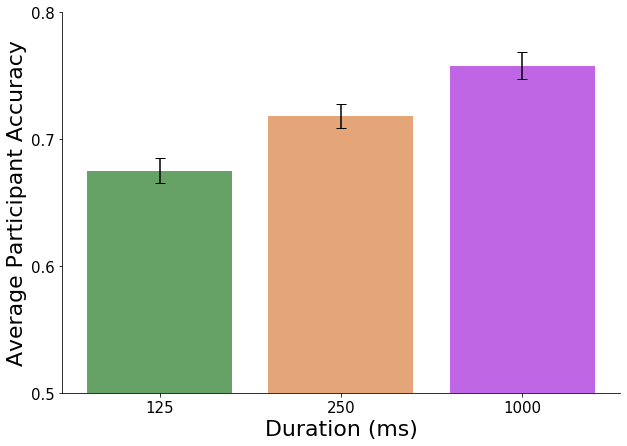

In [262]:
# creating the dataset
durations = ['125', '250', '1000']

avgPC = [np.mean(n_VE_accuracy_125),
         np.mean(n_VE_accuracy_250),
         np.mean(n_VE_accuracy_1000)]


yerrPC = [sem(n_VE_accuracy_125),
         sem(n_VE_accuracy_250),
         sem(n_VE_accuracy_1000)]

fig, ax = plt.subplots(figsize=[10,7])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=15)
plt.ylim(0.5, 0.80)
plt.yticks(np.arange(0.5, 0.80, 0.1),fontsize=15)



# creating the bar plot
plt.bar(durations, avgPC, yerr = yerrPC, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5, alpha=0.6)
 
# plt.title('Verbal Estimate Defined Discrimination Accuracy', fontsize=20)
plt.xlabel("Duration (ms)", fontsize=22)
plt.ylabel("Average Participant Accuracy", fontsize=22)

plt.show()

In [263]:
print('125 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference')
stats.pearsonr(n_VE_accuracy_125, n_VE_estim_diff_125)

125 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference


(0.5574637405174578, 4.069399701563065e-14)

In [264]:
print('250 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference')
stats.pearsonr(n_VE_accuracy_250, n_VE_estim_diff_250)

250 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference


(0.6668897955767396, 2.02354275971296e-21)

In [265]:
print('1000 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference')
stats.pearsonr(n_VE_accuracy_1000, n_VE_estim_diff_1000)

1000 ms: Correlation between VE discrimination accuracy and average z-scored verbal estimate difference


(0.728433206906334, 4.471046240895643e-27)

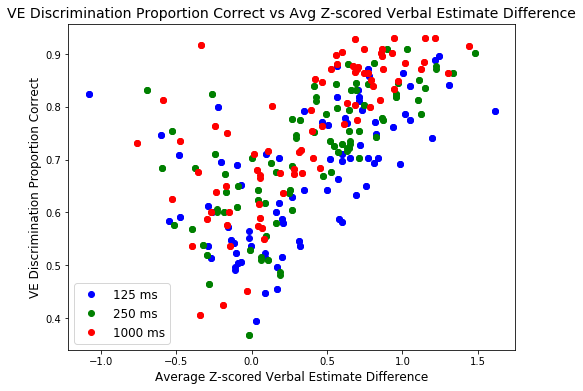

In [266]:
plt.figure(figsize=[8,6])
plt.plot(np.array(n_VE_estim_diff_125), np.array(n_VE_accuracy_125), 'bo', label='125 ms')
plt.plot(np.array(n_VE_estim_diff_250), np.array(n_VE_accuracy_250), 'go', label='250 ms')
plt.plot(np.array(n_VE_estim_diff_1000), np.array(n_VE_accuracy_1000), 'ro', label='1000 ms')
plt.xlabel('Average Z-scored Verbal Estimate Difference', fontsize=12)
plt.ylabel('VE Discrimination Proportion Correct', fontsize = 12)
plt.legend(fontsize = 12)
plt.title('VE Discrimination Proportion Correct vs Avg Z-scored Verbal Estimate Difference', fontsize = 14)
plt.show();

In [267]:
# len(n_VE_accuracy_250)

In [268]:
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

m: [0.24966976]
b: 0.545997692077212
R-squared:  0.5493989816890775


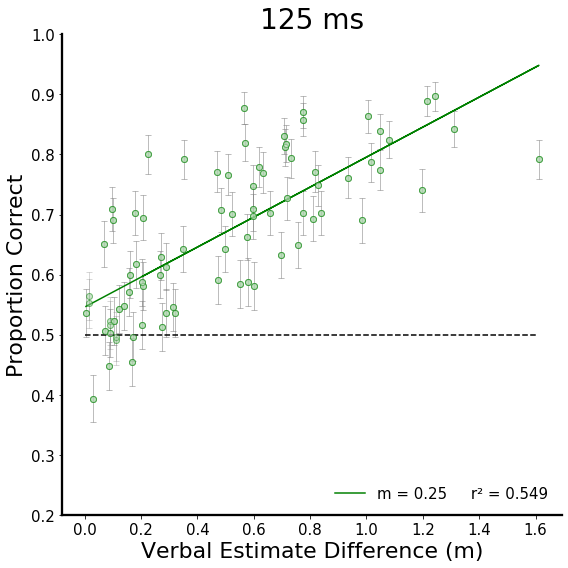

In [269]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)



#run regression
VE_X_125 = np.array(np.abs(n_VE_estim_diff_125).reshape(-1,1))
VE_PC_125 = n_VE_accuracy_125
VE_PC_reg_125 = LinearRegression().fit(VE_X_125, VE_PC_125)

#Generated Predictions
PC_predicted_125 = VE_PC_reg_125.predict(VE_X_125)
#Plot Our Actual and Predicted Values
plt.errorbar(VE_X_125, VE_PC_125,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_125));


plt.plot(VE_X_125, VE_PC_125, 'o', color='green', alpha = 0.3);
plt.plot(VE_X_125, PC_predicted_125,color='green', label = 'm = ' + str(round(VE_PC_reg_125.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_125.score(VE_X_125, VE_PC_125)), 3)))
plt.xlabel("Verbal Estimate Difference (m)", fontsize = 22)
plt.ylabel("Proportion Correct", fontsize = 22)

plt.plot([0, 1.6], [0.5,0.5], '--', color='black')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(0.2,1)

#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_125.coef_))
print("b: {0}".format(VE_PC_reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_125.score(VE_X_125, VE_PC_125))

legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)

plt.title('125 ms', fontsize=28)

fig.tight_layout()

plt.show();

m: [0.25484239]
b: 0.5867824453297654
R-squared:  0.5618835636207506


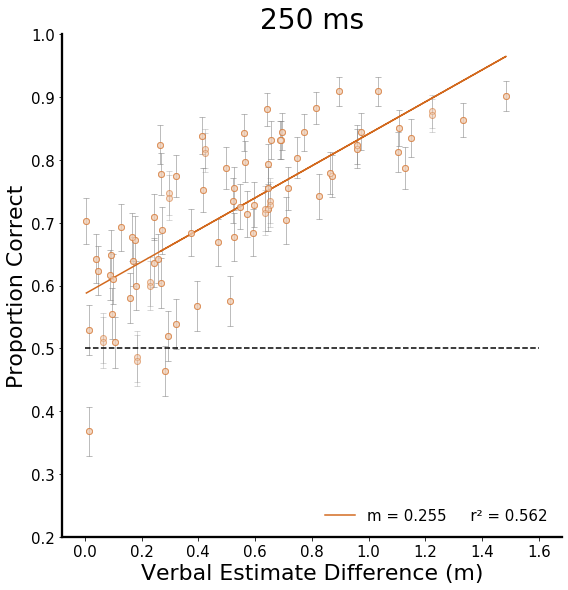

In [270]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
VE_X_250 = np.array(np.abs(n_VE_estim_diff_250).reshape(-1,1))
VE_PC_250 = n_VE_accuracy_250
VE_PC_reg_250 = LinearRegression().fit(VE_X_250, VE_PC_250)

#Generated Predictions
PC_predicted_250 = VE_PC_reg_250.predict(VE_X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(VE_X_250, VE_PC_250,elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_250));


plt.plot(VE_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(VE_X_250, PC_predicted_250,color='chocolate', label = 'm = ' + str(round(VE_PC_reg_250.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_250.score(VE_X_250, VE_PC_250)), 3)))
plt.xlabel("Verbal Estimate Difference (m)", fontsize = 22)
plt.ylabel("Proportion Correct", fontsize = 22)

plt.plot([0, 1.6], [0.5,0.5], '--', color='black')
plt.ylim(0.2,1)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_250.coef_))
print("b: {0}".format(VE_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_250.score(VE_X_250, VE_PC_250))

legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)

fig.tight_layout()

plt.title('250 ms', fontsize=28)


plt.show();

In [271]:
n_stim.index('depth_discrimination_stimuli/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0-target.png')

        

39

depth_discrimination_stimuli/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0-target.png depth_discrimination_stimuli/001056_2014-06-08_18-46-44_260595134347_rgbf000068-resize_0/001056_2014-06-08_18-46-44_260595134347_rgbf000068-resize_0-target.png
m: [0.25484239]
b: 0.5867824453297654
R-squared:  0.5618835636207506


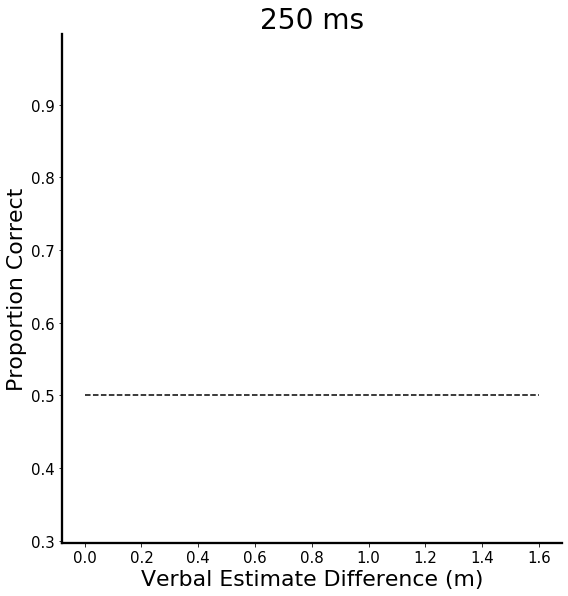

In [272]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)


#run regression
VE_X_250 = np.array(np.abs(n_VE_estim_diff_250).reshape(-1,1))
VE_PC_250 = n_VE_accuracy_250
VE_PC_reg_250 = LinearRegression().fit(VE_X_250, VE_PC_250)

#Generated Predictions
PC_predicted_250 = VE_PC_reg_250.predict(VE_X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(VE_X_250, VE_PC_250,elinewidth=1, ecolor='white', fmt='or', mfc='white', mec='white', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_250));


plt.plot(VE_X_250, VE_PC_250, 'o', color='white', alpha = 0.3);
plt.plot(VE_X_250, PC_predicted_250,color='white', label = 'm = ' + str(round(VE_PC_reg_250.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_250.score(VE_X_250, VE_PC_250)), 3)))
plt.xlabel("Verbal Estimate Difference (m)", fontsize = 22)
plt.ylabel("Proportion Correct", fontsize = 22)

plt.plot([0, 1.6], [0.5,0.5], '--', color='black')


i = 39
# plt.plot(VE_X_250[i], VE_PC_250[i], marker="o", markersize=10, markeredgecolor="black", markerfacecolor="chocolate", alpha=1)

print(n_stim[i], n_all_VE_discrim_performance[n_stim[i]]['stimulus_1'])

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_250.coef_))
print("b: {0}".format(VE_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_250.score(VE_X_250, VE_PC_250))

# legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)

fig.tight_layout()

plt.title('250 ms', fontsize=28)


plt.show();

m: [0.29022618]
b: 0.6053509266593101
R-squared:  0.5716876318488601


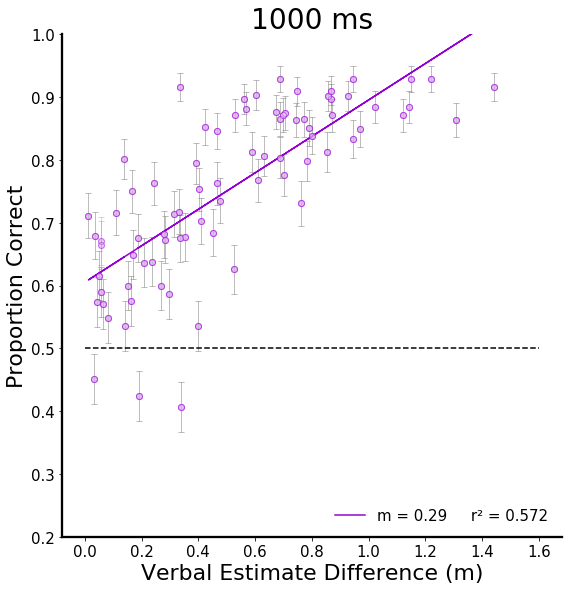

In [273]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)


VE_X_1000 = np.array(np.abs(n_VE_estim_diff_1000).reshape(-1,1))
VE_PC_1000 = n_VE_accuracy_1000
VE_PC_reg_1000 = LinearRegression().fit(VE_X_1000, VE_PC_1000)

#Generated Predictions
PC_predicted_1000 = VE_PC_reg_1000.predict(VE_X_1000)
#Plot Our Actual and Predicted Values

r = np.sqrt(float(VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000)))

plt.errorbar(VE_X_1000, VE_PC_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, yerr = np.array(n_VE_ste_1000));
plt.plot(VE_X_1000, VE_PC_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(VE_X_1000, PC_predicted_1000,color='darkviolet', label = 'm = ' + str(round(VE_PC_reg_1000.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000)), 3)))

legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)

plt.plot([0, 1.6], [0.5,0.5], '--', color='black')
plt.ylim(0.2,1)

# plt.plot(VE_X_1000[2], VE_PC_1000[2], 'o', color='black', alpha=1)

#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_1000.coef_))
print("b: {0}".format(VE_PC_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000))

plt.xlabel("Verbal Estimate Difference (m)", fontsize = 22)
plt.ylabel("Proportion Correct", fontsize = 22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.title("1000 ms: Accuracy", fontsize = 20)

# plt.xticks(np.arange(-1,1.2, 0.2))
# plt.yticks(np.arange(-1,1.2, 0.2))

fig.tight_layout()

plt.title('1000 ms', fontsize=28)


plt.show();

In [274]:
kinectdepthdiffs = [0.31499999999999995,
 0.4885000000000002,
 0.5410000000000001,
 0.9545000000000003,
 1.0160000000000005,
 0.6624999999999996,
 1.1599999999999997,
 0.9754999999999998,
 0.5055000000000003,
 0.967,
 0.3865000000000001,
 0.30299999999999994,
 0.8780000000000001,
 0.4725000000000002,
 0.43533333333330027,
 0.3989999999999991,
 0.8344999999999994,
 0.965,
 0.851,
 0.4800000000000002,
 0.9819999999999998,
 0.6099999999999994,
 0.6844999999999999,
 0.3732499999999999,
 0.9014999999999996,
 0.3595000000000001,
 0.6015000000000006,
 0.3184999999999993,
 0.3029999999999995,
 0.7729999999999997,
 0.29499999999999993,
 0.7220000000000002,
 0.4544999999999999,
 0.7129999999999996,
 0.7050000000000001,
 0.7809999999999993,
 0.5559999999999996,
 0.5695000000000001,
 0.2709999999999999,
 0.6665000000000001,
 0.8540000000000001,
 0.8624999999999998,
 0.266,
 0.5330000000000004,
 0.6154999999999999,
 1.0710000000000002,
 0.31300000000000017,
 0.5586666666667002,
 1.164,
 0.3412500000000005,
 0.5696666666666999,
 1.0065,
 0.33199999999999985,
 0.6919999999999993,
 0.6105,
 0.3099999999999996,
 1.0605000000000002,
 0.7734999999999999,
 0.4584999999999999,
 0.4535,
 0.8170000000000001,
 0.8660000000000001,
 1.0145000000000004,
 0.5640000000000001,
 0.5880000000000003,
 0.4935000000000001,
 1.1810000000000005,
 0.4764999999999999,
 0.7894999999999996,
 0.9015000000000004,
 0.4554999999999994,
 1.2279999999999998,
 0.3600000000000001,
 1.0537499999999995,
 0.417,
 0.3014999999999999,
 0.5565000000000002,
 1.1640000000000001,
 1.0160000000000005,
 1.2279999999999998,
 1.0145000000000004,
 0.5586666666667002,
 0.7220000000000002,
 0.4544999999999999,
 0.43533333333330027,
 0.6624999999999996,
 0.8344999999999994,
 0.5330000000000004,
 1.0537499999999995,
 0.5055000000000003,
 0.266,
 0.3600000000000001,
 0.6105,
 0.5695000000000001,
 0.967,
 0.8660000000000001,
 0.851,
 0.3732499999999999,
 0.9545000000000003,
 0.4554999999999994,
 0.33199999999999985,
 0.3014999999999999,
 0.5640000000000001,
 0.2709999999999999,
 0.417,
 0.30299999999999994,
 0.965,
 0.9754999999999998,
 0.6015000000000006,
 0.3029999999999995,
 1.1599999999999997,
 1.164,
 0.4725000000000002,
 1.1810000000000005,
 0.7129999999999996,
 0.4535,
 0.9014999999999996,
 0.3865000000000001,
 0.8780000000000001,
 1.1640000000000001,
 0.6099999999999994,
 0.29499999999999993,
 0.7050000000000001,
 1.0605000000000002,
 1.0710000000000002,
 0.5880000000000003,
 0.4764999999999999,
 0.31499999999999995,
 0.4885000000000002,
 0.5559999999999996,
 0.6154999999999999,
 0.7809999999999993,
 0.5696666666666999,
 0.5565000000000002,
 1.0065,
 0.6844999999999999,
 0.7729999999999997,
 0.9819999999999998,
 0.5410000000000001,
 0.3412500000000005,
 0.3595000000000001,
 0.8540000000000001,
 0.3989999999999991,
 0.6665000000000001,
 0.3184999999999993,
 0.3099999999999996,
 0.8624999999999998,
 0.7734999999999999,
 0.31300000000000017,
 0.7894999999999996,
 0.8170000000000001,
 0.9015000000000004,
 0.4935000000000001,
 0.6919999999999993,
 0.4800000000000002,
 0.4584999999999999]

In [275]:
# kinectdepthdiffs, n_VE_estim_diff_1000

Text(0, 0.5, 'Proportion Correct')

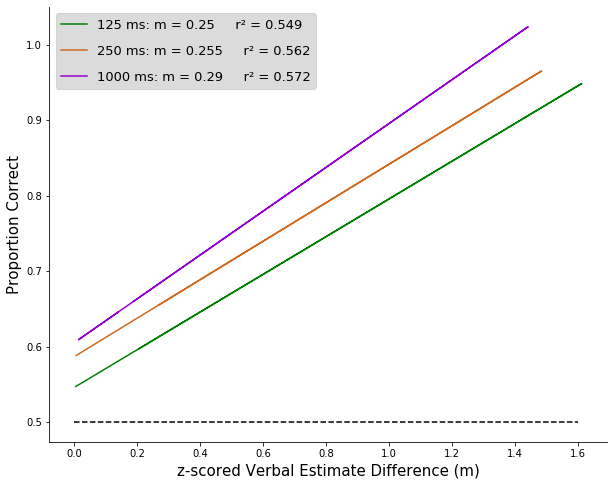

In [276]:
fig, ax = plt.subplots(figsize=[10,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

plt.plot(VE_X_125, PC_predicted_125,color='green', label = '125 ms: m = ' + str(round(VE_PC_reg_125.coef_[0], 2))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_125.score(VE_X_125, VE_PC_125)), 3)))
plt.plot(VE_X_250, PC_predicted_250,color='chocolate', label = '250 ms: m = ' + str(round(VE_PC_reg_250.coef_[0], 3))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_250.score(VE_X_250, VE_PC_250)), 3)))
plt.plot(VE_X_1000, PC_predicted_1000,color='darkviolet', label = '1000 ms: m = ' + str(round(VE_PC_reg_1000.coef_[0], 2))
         + '     r' + get_super('2') + ' = '+ str(round(float(VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000)), 3)))

legend = plt.legend(loc = 0, fontsize=13, labelspacing=1, frameon=True, facecolor='lightgray')

plt.plot([0, 1.6], [0.5,0.5], '--', color='black')

plt.xlabel("z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("Proportion Correct", fontsize = 15)

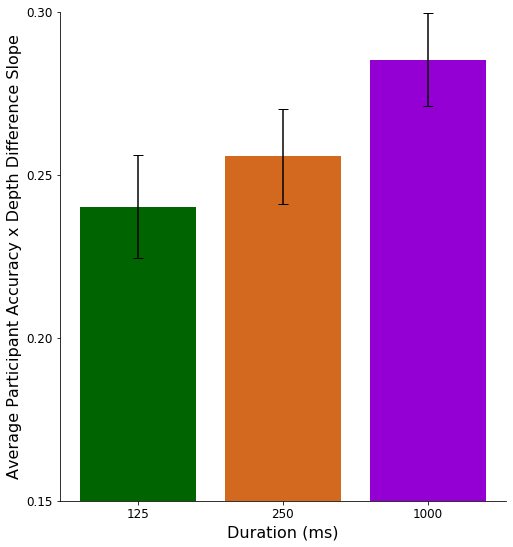

In [277]:
# creating the dataset
durations = ['125', '250', '1000']

zs_PC = [np.mean(all_subj_acc_slopes[125]), np.mean(all_subj_acc_slopes[250]), np.mean(all_subj_acc_slopes[1000])]
zs_PC_avg_sem = [sem(all_subj_acc_slopes[125]), sem(all_subj_acc_slopes[250]), sem(all_subj_acc_slopes[1000])]

fig, ax = plt.subplots(figsize=[8,9])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=12)
plt.ylim(0.15, 0.3)
plt.yticks(np.arange(0.15, 0.35, 0.05),fontsize=12)



# creating the bar plot
plt.bar(durations, zs_PC, yerr = zs_PC_avg_sem, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5)
 
# plt.title('Verbal Estimate Defined Discrimination Accuracy', fontsize=20)
plt.xlabel("Duration (ms)", fontsize=16)
plt.ylabel("Average Participant Accuracy x Depth Difference Slope", fontsize=16)

plt.show()

In [278]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(all_subj_acc_slopes[125], all_subj_acc_slopes[250], all_subj_acc_slopes[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_subj_acc_slopes[125], all_subj_acc_slopes[250])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_subj_acc_slopes[125], all_subj_acc_slopes[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_subj_acc_slopes[250], all_subj_acc_slopes[1000])
print(fvalue, pvalue)

2.393737612457406 0.09241679975429712
0.5191691774419879 0.4717427899139798
4.529048293746004 0.03411528221370558
2.1396485728649273 0.14455113276418122


In [279]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(subj_acc[125], subj_acc[250], subj_acc[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(subj_acc[125], subj_acc[250])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(subj_acc[125], subj_acc[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(subj_acc[250], subj_acc[1000])
print(fvalue, pvalue)

7.015759161371818 0.0009962117299780406
5.237403155897502 0.022783201260219262
13.136597893282255 0.00033850878690090566
2.1852867967344394 0.14035369776056808


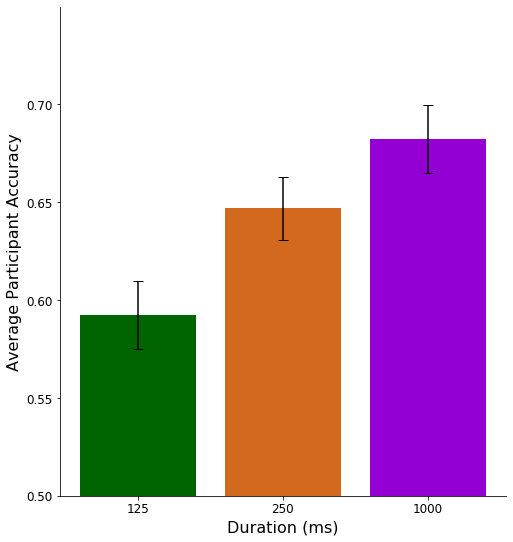

In [280]:
# creating the dataset
durations = ['125', '250', '1000']

zs_PC = [np.mean(subj_acc[125]), np.mean(subj_acc[250]), np.mean(subj_acc[1000])]
zs_PC_avg_sem = [sem(subj_acc[125]), sem(subj_acc[250]), sem(subj_acc[1000])]

fig, ax = plt.subplots(figsize=[8,9])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=12)
plt.ylim(0.5, 0.75)
plt.yticks(np.arange(0.5, 0.75, 0.05),fontsize=12)



# creating the bar plot
plt.bar(durations, zs_PC, yerr = zs_PC_avg_sem, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5)
 
# plt.title('Verbal Estimate Defined Discrimination Accuracy', fontsize=20)
plt.xlabel("Duration (ms)", fontsize=16)
plt.ylabel("Average Participant Accuracy", fontsize=16)

plt.show()

In [281]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(n_VE_accuracy_125, n_VE_accuracy_250, n_VE_accuracy_1000)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_VE_accuracy_125, n_VE_accuracy_250)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_VE_accuracy_125, n_VE_accuracy_1000)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_VE_accuracy_250, n_VE_accuracy_1000)
print(fvalue, pvalue)

16.968619179281102 7.711438673132937e-08
9.807592090385164 0.0019037231836092389
32.30644493129954 3.039019853293511e-08
7.702325691018316 0.00584992825199618


In [282]:
stats.pearsonr(n_VE_accuracy_250, n_VE_accuracy_125)

(0.8392426550740635, 1.3639075924021415e-42)

In [283]:
stats.pearsonr(n_VE_accuracy_125, n_VE_accuracy_1000)

(0.7446619099708287, 7.815861736825365e-29)

In [284]:
stats.pearsonr(n_VE_accuracy_250, n_VE_accuracy_1000)

(0.8473617178500831, 3.5067577251361085e-44)

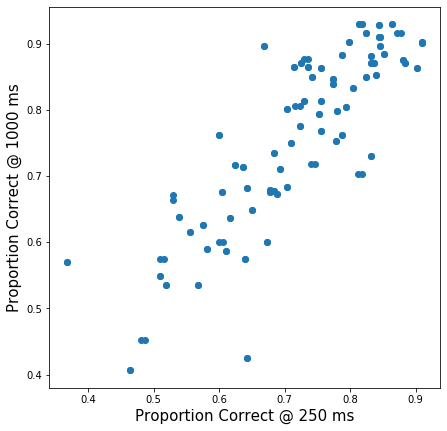

In [285]:
plt.figure(figsize=[7,7])
plt.xlabel('Proportion Correct @ 250 ms', fontsize=15)
plt.ylabel('Proportion Correct @ 1000 ms', fontsize=15)
plt.plot(n_VE_accuracy_250,n_VE_accuracy_1000, 'o' )

In [286]:
stats.pearsonr(n_VE_estim_diff_125, n_avg_RT_125)

(-0.38662254130689133, 6.185795327901297e-07)

m: [-128.6802676]
b: 1314.7293167104442
R-squared:  0.2299477926573773


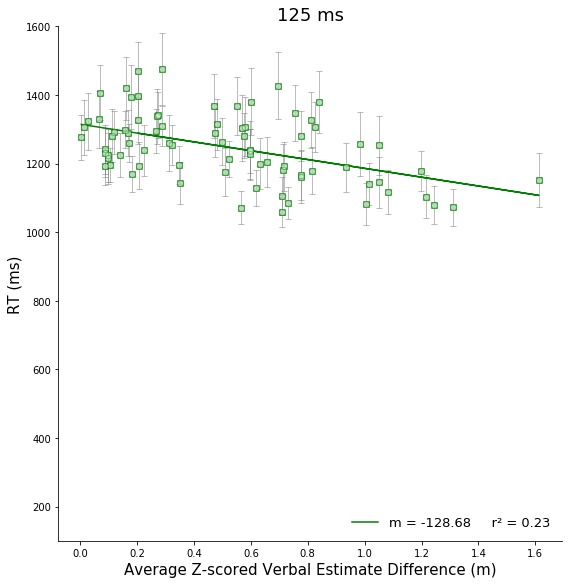

In [287]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_125 = np.array(np.abs(n_VE_estim_diff_125).reshape(-1,1))
y_125 = n_avg_RT_125
reg_125 = LinearRegression().fit(X_125, y_125)

#Generated Predictions
y_predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.errorbar(X_125, y_125,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_125));

plt.plot(X_125, y_125, 's', color='green', alpha = 0.3);
plt.plot(X_125, y_predicted_125,color='green', label = 'm = ' + str(round(reg_125.coef_[0], 2))
        + '     r' + get_super('2') + ' = '+ str(round(float(reg_125.score(X_125, y_125)), 3)))

plt.xlabel("Average Z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

plt.ylim(100, 1600)

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

plt.title('125 ms', fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_125.coef_))
print("b: {0}".format(reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_125.score(X_125, y_125))

In [288]:
# n_avg_RT_250

In [289]:
stats.pearsonr(n_VE_estim_diff_250, n_avg_RT_250)

(-0.5673403055402917, 1.144983855133599e-14)

m: [-119.8150977]
b: 1095.0082435547124
R-squared:  0.2851738781192972


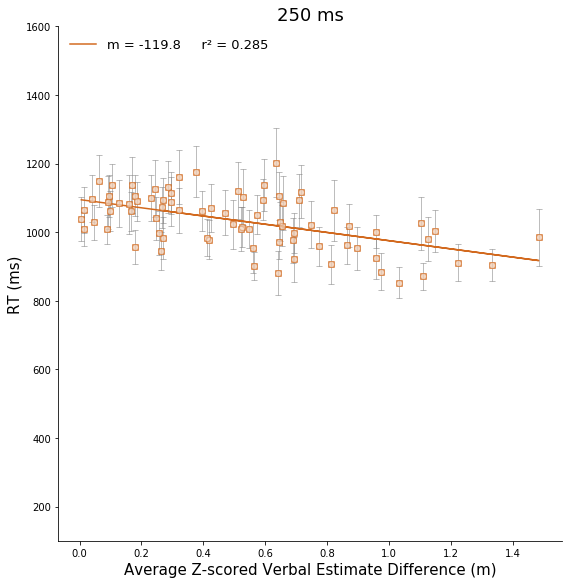

In [290]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_250 = np.array(np.abs(n_VE_estim_diff_250).reshape(-1,1))
y_250 = n_avg_RT_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(X_250, y_250,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_250));

plt.plot(X_250, y_250, 's', color='chocolate', alpha = 0.3);
plt.plot(X_250, y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 1))
        + '     r' + get_super('2') + ' = '+ str(round(float(reg_250.score(X_250, y_250)), 3)))

plt.xlabel("Average Z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

plt.ylim(100, 1600)


legend = plt.legend(loc = 2, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

# plt.xticks(np.arange(0.15,1.2, 0.2))
# plt.yticks(np.arange(6.7,7.3, .1))

plt.title('250 ms', fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

In [291]:
stats.pearsonr(n_VE_estim_diff_1000, n_avg_RT_1000)

(-0.5043142767586988, 1.918327626204416e-11)

In [292]:
# n_avg_RT_1000

m: [-79.53585073]
b: 425.80960034357815
R-squared:  0.1546070765789077


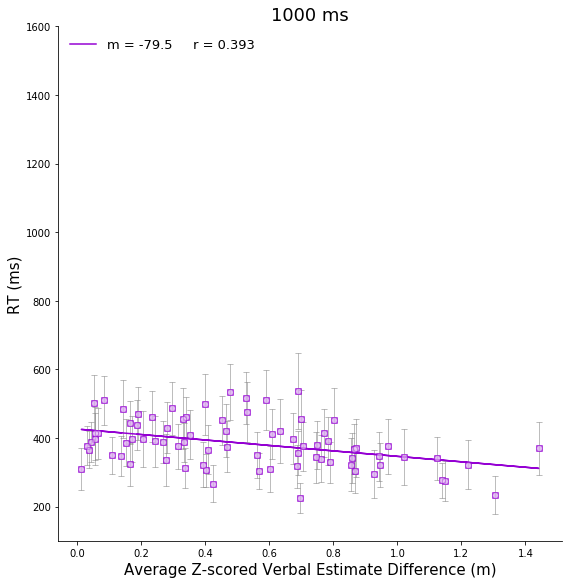

In [293]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_1000 = np.array(np.abs(n_VE_estim_diff_1000).reshape(-1,1))
y_1000 = n_avg_RT_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values

plt.errorbar(X_1000, y_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_1000));

r_1000 = np.sqrt(float(reg_1000.score(X_1000, y_1000)))

plt.plot(X_1000, y_1000, 's', color='darkviolet', alpha = 0.3);
plt.plot(X_1000, y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(reg_1000.coef_[0], 1))
        + '     r = '+ str(round(float(r_1000), 3)))

plt.xlabel("Average Z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)
plt.ylim(100, 1600)


legend = plt.legend(loc = 2, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

# plt.yticks(np.arange(6.7,7.3, .1))

plt.title('1000 ms', fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

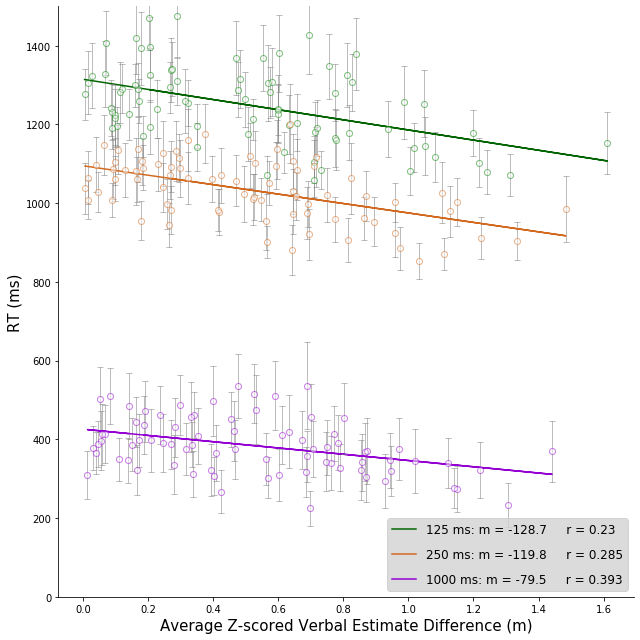

In [294]:
fig, ax = plt.subplots(figsize=[9,9])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

plt.plot(X_125, y_predicted_125,color='darkgreen', label = '125 ms: m = ' + str(round(reg_125.coef_[0], 1))
        + '     r = '+ str(round(float(reg_125.score(X_125, y_125)), 3)))
plt.errorbar(X_125, y_125,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_125));


plt.errorbar(X_250, y_250,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_250));
plt.plot(X_250, y_predicted_250,color='chocolate', label = '250 ms: m = ' + str(round(reg_250.coef_[0], 1))
        + '     r = '+ str(round(float(reg_250.score(X_250, y_250)), 3)))


plt.plot(X_1000, y_predicted_1000,color='darkviolet', label = '1000 ms: m = ' + str(round(reg_1000.coef_[0], 1))
        + '     r = '+ str(round(float(r_1000), 3)))
plt.errorbar(X_1000, y_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_1000));


plt.xlabel("Average Z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)
plt.ylim(0, 1500)


legend = plt.legend(loc = 4, fontsize=12, labelspacing=1, frameon=True, facecolor='lightgray')

fig.tight_layout()



## Z-scored RT

In [295]:
stats.pearsonr(n_VE_estim_diff_125, n_avg_zsRT_125)

(-0.4601545038286041, 1.5073516434821798e-09)

m: [-0.27662153]
b: -124.85667995712306
R-squared:  0.328134016625207


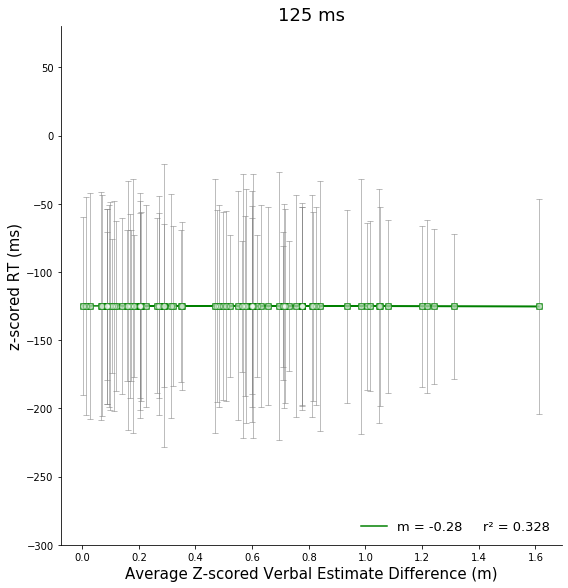

In [296]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_125 = np.array(np.abs(n_VE_estim_diff_125).reshape(-1,1))
y_125 = n_avg_zsRT_125
reg_125 = LinearRegression().fit(X_125, y_125)

#Generated Predictions
y_predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.errorbar(X_125, y_125,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_125));

plt.plot(X_125, y_125, 's', color='green', alpha = 0.3);
plt.plot(X_125, y_predicted_125,color='green', label = 'm = ' + str(round(reg_125.coef_[0], 2))
        + '     r' + get_super('2') + ' = '+ str(round(float(reg_125.score(X_125, y_125)), 3)))

plt.xlabel("Average Z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("z-scored RT (ms)", fontsize = 15)

plt.ylim(-300, 80)

legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

plt.title('125 ms', fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_125.coef_))
print("b: {0}".format(reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_125.score(X_125, y_125))

In [297]:
# stats.pearsonr(n_VE_estim_diff_250, n_avg_zsRT_250)

m: [-0.3026137]
b: -249.84434460863716
R-squared:  0.4303840137308994


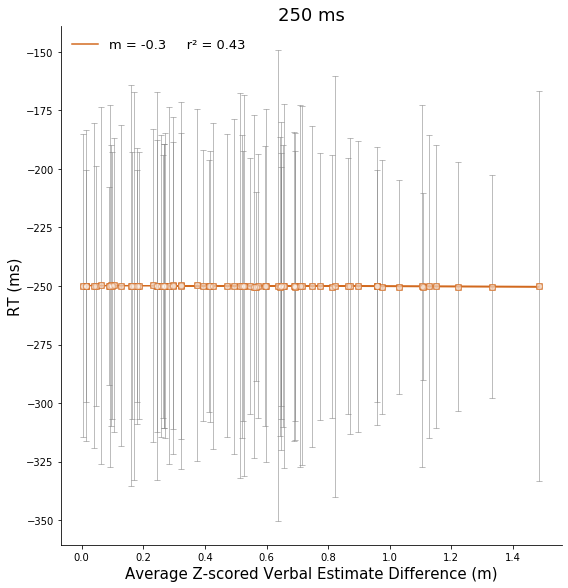

In [299]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_250 = np.array(np.abs(n_VE_estim_diff_250).reshape(-1,1))
y_250 = n_avg_zsRT_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(X_250, y_250,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_250));

plt.plot(X_250, y_250, 's', color='chocolate', alpha = 0.3);
plt.plot(X_250, y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 1))
        + '     r' + get_super('2') + ' = '+ str(round(float(reg_250.score(X_250, y_250)), 3)))

plt.xlabel("Average Z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

# plt.ylim(100, 1600)


legend = plt.legend(loc = 2, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

# plt.xticks(np.arange(0.15,1.2, 0.2))
# plt.yticks(np.arange(6.7,7.3, .1))

plt.title('250 ms', fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

In [300]:
stats.pearsonr(n_VE_estim_diff_1000, n_avg_zsRT_1000)

(-0.5881537418819294, 6.858022599009973e-16)

In [1189]:
# n_avg_RT_1000

m: [-0.18651188]
b: -999.9021934648551
R-squared:  0.2618729550760934


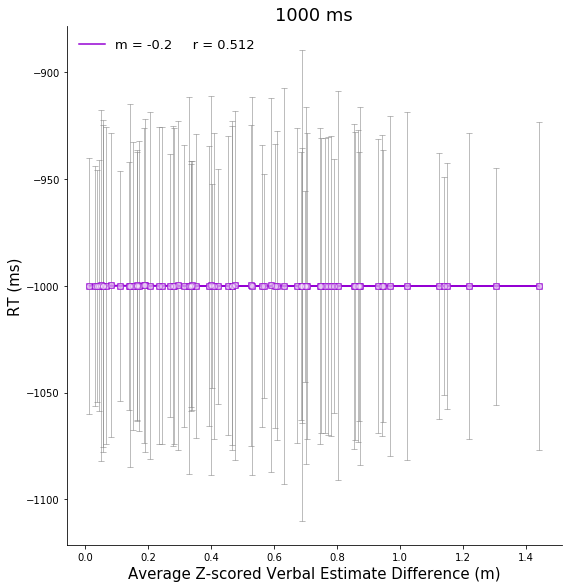

In [301]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_1000 = np.array(np.abs(n_VE_estim_diff_1000).reshape(-1,1))
y_1000 = n_avg_zsRT_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values

plt.errorbar(X_1000, y_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_1000));

r_1000 = np.sqrt(float(reg_1000.score(X_1000, y_1000)))

plt.plot(X_1000, y_1000, 's', color='darkviolet', alpha = 0.3);
plt.plot(X_1000, y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(reg_1000.coef_[0], 1))
        + '     r = '+ str(round(float(r_1000), 3)))

plt.xlabel("Average Z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)
# plt.ylim(-300, 80)


legend = plt.legend(loc = 2, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

# plt.yticks(np.arange(6.7,7.3, .1))

plt.title('1000 ms', fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

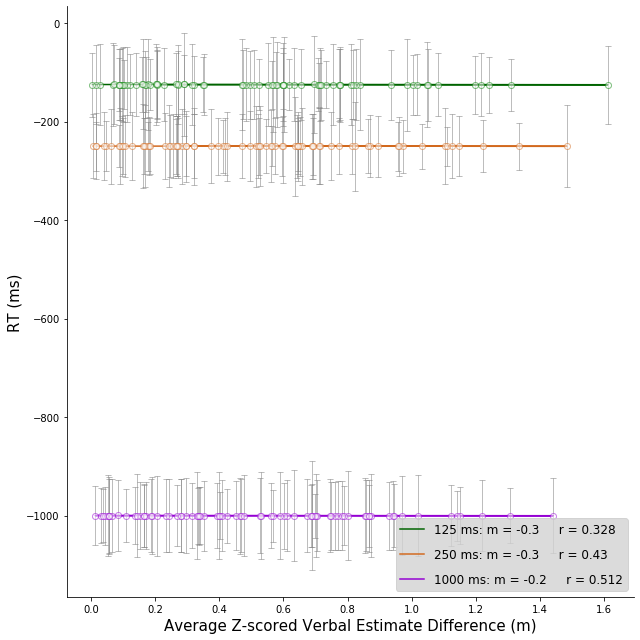

In [302]:
fig, ax = plt.subplots(figsize=[9,9])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

plt.plot(X_125, y_predicted_125,color='darkgreen', label = '125 ms: m = ' + str(round(reg_125.coef_[0], 1))
        + '     r = '+ str(round(float(reg_125.score(X_125, y_125)), 3)))
plt.errorbar(X_125, y_125,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='green', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_125));


plt.errorbar(X_250, y_250,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_250));
plt.plot(X_250, y_predicted_250,color='chocolate', label = '250 ms: m = ' + str(round(reg_250.coef_[0], 1))
        + '     r = '+ str(round(float(reg_250.score(X_250, y_250)), 3)))


plt.plot(X_1000, y_predicted_1000,color='darkviolet', label = '1000 ms: m = ' + str(round(reg_1000.coef_[0], 1))
        + '     r = '+ str(round(float(r_1000), 3)))
plt.errorbar(X_1000, y_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, yerr = np.array(n_avg_RT_ste_1000));


plt.xlabel("Average Z-scored Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)
# plt.ylim(0, 1500)


legend = plt.legend(loc = 4, fontsize=12, labelspacing=1, frameon=True, facecolor='lightgray')

fig.tight_layout()



## Subject RT

In [303]:
# n_VE_estim_diff_250



In [304]:
all_mean_subj_RTs = {125: [], 250: [], 1000: []}

all_subj_RTs_slopes = {125: [], 250: [], 1000: []}


aks = {125: n_VE_answerkey_125, 250: n_VE_answerkey_250, 1000: n_VE_answerkey_1000}

for subj in zscored_data.subjID.unique():
    
    subj_df = zscored_data.loc[zscored_data['subjID']==subj]
    s_duration = subj_df.duration.unique()[0]
    
    mean_subj_RTs = np.mean(np.array(subj_df['cleaned_RT']))
    
    
    s_ak = aks[s_duration]
    
    s_stim = [elem for elem in subj_df.stimulus_0.unique() if type(elem) == str]
    
    subj_depthdiff = []
    subj_trialRT = []

    for stim0 in s_stim:
        stim_subj_df = subj_df.loc[subj_df['stimulus_0']==stim0]
        depthdiff = n_all_VE_discrim_performance[stim0]['VE_depthdifference_' + str(int(s_duration))]
        subj_depthdiff.append(depthdiff)
        subj_trialRT.append(stim_subj_df.trial_RT.unique()[0])
        
    
    #run regression
    X = np.array(np.abs(subj_depthdiff).reshape(-1,1))
    y = subj_trialRT
    reg = LinearRegression().fit(X, y)

    all_subj_RTs_slopes[s_duration].append(reg.coef_[0])


        
    all_mean_subj_RTs[s_duration].append(mean_subj_RTs)


    
    

In [305]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(all_subj_RTs_slopes[125], all_subj_RTs_slopes[250], all_subj_RTs_slopes[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_subj_RTs_slopes[125], all_subj_RTs_slopes[250])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_subj_RTs_slopes[125], all_subj_RTs_slopes[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_subj_RTs_slopes[250], all_subj_RTs_slopes[1000])
print(fvalue, pvalue)

1.6270405316335266 0.19763180403212638
0.0672388434750221 0.7955735047276226
2.3242306282836753 0.12839598400187419
2.1902140066310554 0.13990882170178054


In [306]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(all_mean_subj_RTs[125], all_mean_subj_RTs[250], all_mean_subj_RTs[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_mean_subj_RTs[125], all_mean_subj_RTs[250])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_mean_subj_RTs[125], all_mean_subj_RTs[1000])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(all_mean_subj_RTs[250], all_mean_subj_RTs[1000])
print(fvalue, pvalue)

1.9474354286279003 0.14380602686638425
2.376332032983506 0.12421323811567447
0.05197502746388601 0.8198123219603056
3.914799742906312 0.048750453644792545


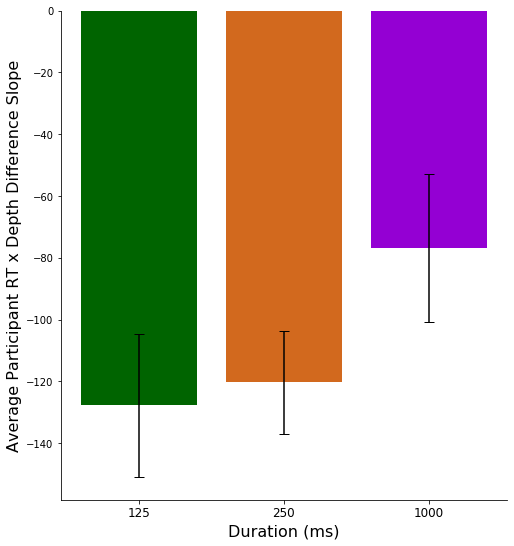

In [307]:
# creating the dataset
durations = ['125', '250', '1000']

zs_RT = [np.mean(all_subj_RTs_slopes[125]), np.mean(all_subj_RTs_slopes[250]), np.mean(all_subj_RTs_slopes[1000])]
zs_RT_avg_sem = [sem(all_subj_RTs_slopes[125]), sem(all_subj_RTs_slopes[250]), sem(all_subj_RTs_slopes[1000])]

fig, ax = plt.subplots(figsize=[8,9])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=12)
# plt.ylim(1000, 2500)
# plt.yticks(np.arange(0.1, 0.35, 0.05),fontsize=12)


# creating the bar plot
plt.bar(durations, zs_RT, yerr = zs_RT_avg_sem, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5)
 
# plt.title('Verbal Estimate Defined Discrimination Accuracy', fontsize=20)
plt.xlabel("Duration (ms)", fontsize=16)
plt.ylabel("Average Participant RT x Depth Difference Slope", fontsize=16)

plt.show()

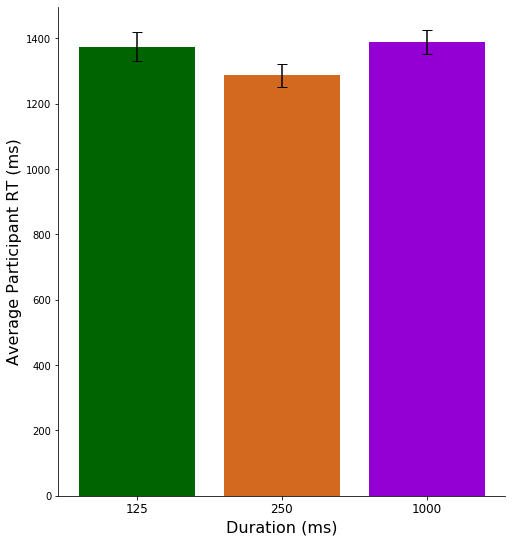

In [308]:
# creating the dataset
durations = ['125', '250', '1000']

zs_RT = [np.mean(all_mean_subj_RTs[125]), np.mean(all_mean_subj_RTs[250]), np.mean(all_mean_subj_RTs[1000])]
zs_RT_avg_sem = [sem(all_mean_subj_RTs[125]), sem(all_mean_subj_RTs[250]), sem(all_mean_subj_RTs[1000])]

fig, ax = plt.subplots(figsize=[8,9])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=12)
# plt.ylim(1000, 2500)
# plt.yticks(np.arange(0.1, 0.35, 0.05),fontsize=12)


# creating the bar plot
plt.bar(durations, zs_RT, yerr = zs_RT_avg_sem, color = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5)
 
# plt.title('Verbal Estimate Defined Discrimination Accuracy', fontsize=20)
plt.xlabel("Duration (ms)", fontsize=16)
plt.ylabel("Average Participant RT (ms)", fontsize=16)

plt.show()

In [309]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(n_avg_RT_125, n_avg_RT_250, n_avg_RT_1000)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_avg_RT_125, n_avg_RT_250)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_avg_RT_125, n_avg_RT_1000)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(n_avg_RT_250, n_avg_RT_1000)
print(fvalue, pvalue)

4584.524078617384 8.856508721706257e-307
457.4897093412525 5.522452461132774e-63
8018.010759503316 1.3843854140268344e-223
5949.4213323194745 2.3180883150521455e-204


## Is discrimination performance better for targets that are closer or further away?

n_VE_estim_diff_125 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_125'] for elem in n_all_VE_discrim_performance]
n_VE_estim_diff_250 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_250'] for elem in n_all_VE_discrim_performance]
n_VE_estim_diff_1000 = [n_all_VE_discrim_performance[elem]['VE_depthdifference_1000'] for elem in n_all_VE_discrim_performance]

n_VE_accuracy_125 = [n_all_VE_discrim_performance[elem]['accuracy_125'][0] for elem in n_all_VE_discrim_performance]
n_VE_accuracy_250 = [n_all_VE_discrim_performance[elem]['accuracy_250'][0] for elem in n_all_VE_discrim_performance]
n_VE_accuracy_1000 = [n_all_VE_discrim_performance[elem]['accuracy_1000'][0] for elem in n_all_VE_discrim_performance]

n_VE_ste_125 = [n_all_VE_discrim_performance[elem]['accuracy_125'][-2] for elem in n_all_VE_discrim_performance]
n_VE_ste_250 = [n_all_VE_discrim_performance[elem]['accuracy_250'][-2] for elem in n_all_VE_discrim_performance]
n_VE_ste_1000 = [n_all_VE_discrim_performance[elem]['accuracy_1000'][-2] for elem in n_all_VE_discrim_performance]

n_avg_RT_125 = [n_all_VE_discrim_performance[elem]['RT_125'][1]-125 for elem in n_all_VE_discrim_performance]
n_avg_RT_250 = [n_all_VE_discrim_performance[elem]['RT_250'][1]-250 for elem in n_all_VE_discrim_performance]
n_avg_RT_1000 = [n_all_VE_discrim_performance[elem]['RT_1000'][1]-1000 for elem in n_all_VE_discrim_performance]

n_avg_RT_ste_125 = [n_all_VE_discrim_performance[elem]['RT_125'][-1] for elem in n_all_VE_discrim_performance]
n_avg_RT_ste_250 = [n_all_VE_discrim_performance[elem]['RT_250'][-1] for elem in n_all_VE_discrim_performance]
n_avg_RT_ste_1000 = [n_all_VE_discrim_performance[elem]['RT_1000'][-1] for elem in n_all_VE_discrim_performance]

n_JV_125 = [n_all_VE_discrim_performance[elem]['JV_regressor_125'] for elem in n_all_VE_discrim_performance]
n_JV_250 = [n_all_VE_discrim_performance[elem]['JV_regressor_250'] for elem in n_all_VE_discrim_performance]
n_JV_1000 = [n_all_VE_discrim_performance[elem]['JV_regressor_1000'] for elem in n_all_VE_discrim_performance]

n_kinectanswer_125 = [n_all_VE_discrim_performance[elem]['kinect_answer_125'] for elem in n_all_VE_discrim_performance]
n_kinectanswer_250 = [n_all_VE_discrim_performance[elem]['kinect_answer_250'] for elem in n_all_VE_discrim_performance]
n_kinectanswer_1000 = [n_all_VE_discrim_performance[elem]['kinect_answer_1000'] for elem in n_all_VE_discrim_performance]

n_stim = [elem for elem in n_all_VE_discrim_performance]

In [310]:
n_VE_avg_depth_125 = [n_all_VE_discrim_performance[elem]['VE_avg_depth_125'] for elem in n_all_VE_discrim_performance]
n_VE_avg_depth_250 = [n_all_VE_discrim_performance[elem]['VE_avg_depth_250'] for elem in n_all_VE_discrim_performance]
n_VE_avg_depth_1000 = [n_all_VE_discrim_performance[elem]['VE_avg_depth_1000'] for elem in n_all_VE_discrim_performance]


In [311]:
scipy.stats.pearsonr(n_VE_avg_depth_125, n_VE_accuracy_125)

(-0.27836029355540604, 0.00043389373671823424)

In [312]:
scipy.stats.pearsonr(n_VE_avg_depth_250, n_VE_accuracy_250)

(-0.3557289973815052, 5.1817975653601004e-06)

In [313]:
scipy.stats.pearsonr(n_VE_avg_depth_1000, n_VE_accuracy_1000)

(-0.3212531735077125, 4.3303869879814456e-05)

In [314]:

# zipped_125 = zip(n_avg_depth, n_VE_accuracy_125)

# res_125 = sorted(zipped_125)

# unzipped_125 = [[i for i, j in res_125],
#        [j for i, j in res_125]]

# avg

m: [-0.06317054]
b: 0.6752947529970841
R-squared:  0.07664455565936135


0.077

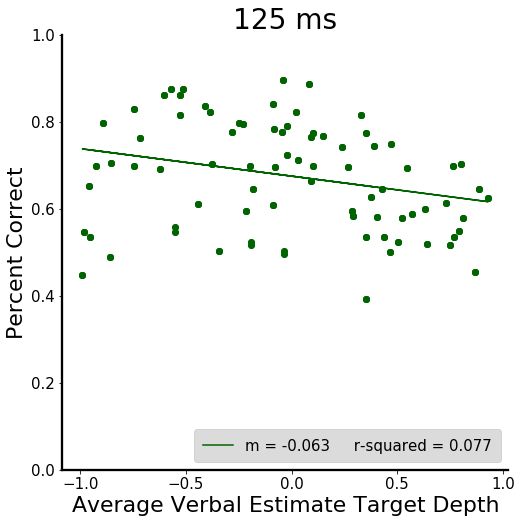

In [109]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.title("125 ms", fontsize = 28)
plt.xlabel("Average Verbal Estimate Target Depth", fontsize = 22)
plt.ylabel("Percent Correct", fontsize = 22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#run regression
X = np.array(n_VE_avg_depth_125).reshape(-1,1)
y = n_VE_accuracy_125
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='darkgreen', alpha = 0.5);
plt.plot(X,y_predicted,color='darkgreen', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
# plt.title("1000 ms", fontsize = 20)
# plt.xlabel("Actual Depth (m)", fontsize = 15)
# plt.ylabel("Estimated Depth", fontsize = 15)
plt.errorbar(X, y, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)

legend = plt.legend(loc = 4, fontsize = 15, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.xticks(np.arange(-1,1.5,0.5))

plt.ylim(0,1)
#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)



m: [-0.07312265]
b: 0.7174908618360325
R-squared:  0.12373859002926735


0.124

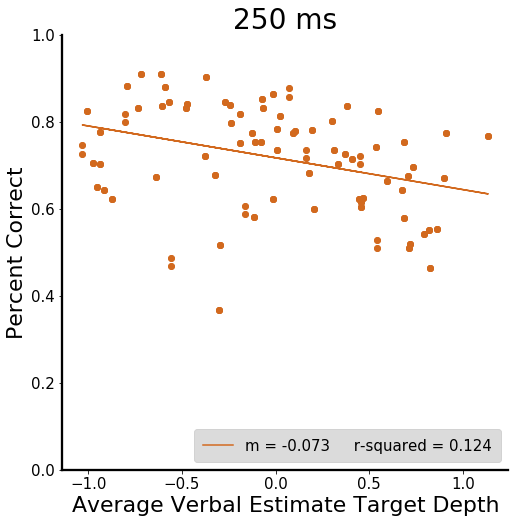

In [110]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.title("250 ms", fontsize = 28)
plt.xlabel("Average Verbal Estimate Target Depth", fontsize = 22)
plt.ylabel("Percent Correct", fontsize = 22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#run regression
X = np.array(n_VE_avg_depth_250).reshape(-1,1)
y = n_VE_accuracy_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='chocolate', alpha = 0.5);
plt.plot(X,y_predicted,color='chocolate', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
# plt.title("1000 ms", fontsize = 20)
# plt.xlabel("Actual Depth (m)", fontsize = 15)
# plt.ylabel("Estimated Depth", fontsize = 15)
plt.errorbar(X, y, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 4, fontsize = 15, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


plt.ylim(0,1)
#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

m: [-0.07205156]
b: 0.7577450892310892
R-squared:  0.10320360148877661


0.103

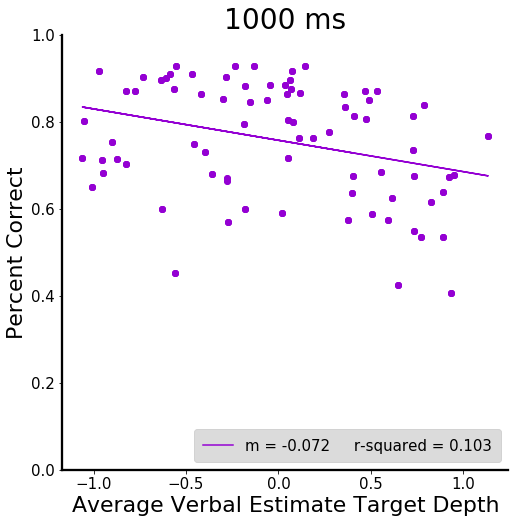

In [111]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.title("1000 ms", fontsize = 28)
plt.xlabel("Average Verbal Estimate Target Depth", fontsize = 22)
plt.ylabel("Percent Correct", fontsize = 22)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#run regression
X = np.array(n_VE_avg_depth_1000).reshape(-1,1)
y = n_VE_accuracy_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='darkviolet', alpha = 0.5);
plt.plot(X,y_predicted,color='darkviolet', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
# plt.title("1000 ms", fontsize = 20)
# plt.xlabel("Actual Depth (m)", fontsize = 15)
# plt.ylabel("Estimated Depth", fontsize = 15)
plt.errorbar(X, y, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)

legend = plt.legend(loc = 4, fontsize = 15, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


plt.ylim(0,1)
#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)